Feature customerID has 7032 unique categories
Feature gender has 2 unique categories
Feature SeniorCitizen has 2 unique categories
Feature Partner has 2 unique categories
Feature Dependents has 2 unique categories
Feature tenure has 72 unique categories
Feature PhoneService has 2 unique categories
Feature MultipleLines has 3 unique categories
Feature InternetService has 3 unique categories
Feature OnlineSecurity has 3 unique categories
Feature OnlineBackup has 3 unique categories
Feature DeviceProtection has 3 unique categories
Feature TechSupport has 3 unique categories
Feature StreamingTV has 3 unique categories
Feature StreamingMovies has 3 unique categories
Feature Contract has 3 unique categories
Feature PaperlessBilling has 2 unique categories
Feature PaymentMethod has 4 unique categories
Feature MonthlyCharges has 1584 unique categories
Feature TotalCharges has 6530 unique categories
Feature Churn has 2 unique categories
1) 0.847 (+/-0.013) for {'activation': 'identity', 'alpha'

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1038
           1       0.66      0.56      0.61       369

   micro avg       0.81      0.81      0.81      1407
   macro avg       0.76      0.73      0.74      1407
weighted avg       0.80      0.81      0.80      1407

[[931 107]
 [161 208]]


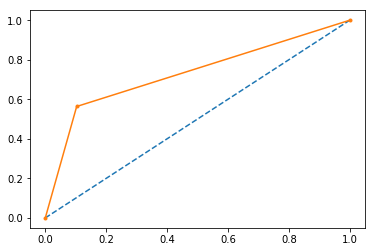

AUC: 0.730


"MLPClassifier(activation='logistic', alpha=1e-06, batch_size='auto',\n       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,\n       hidden_layer_sizes=50, learning_rate='constant',\n       learning_rate_init=0.001, max_iter=200, momentum=0.9,\n       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,\n       random_state=None, shuffle=True, solver='adam', tol=0.0001,\n       validation_fraction=0.1, verbose=False, warm_start=False)"

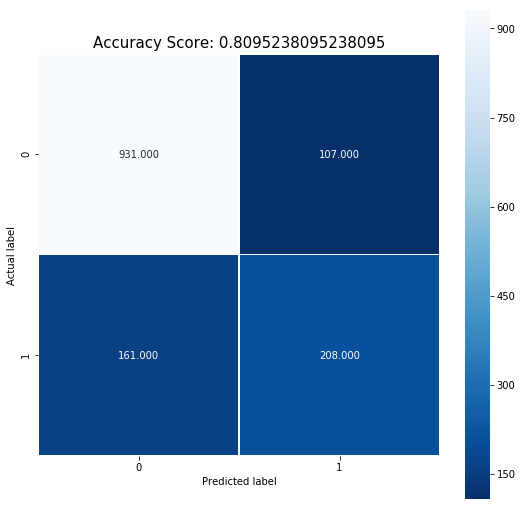

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov  1 22:55:22 2018

@author: Shivam Soni
"""

import numpy as np
import matplotlib.pyplot as pt
import pandas as pd
import statsmodels.stats.outliers_influence as oi
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

df=pd.read_csv('Churn.csv')

"""----------------------------DATA PREPARATION--------------------------"""

for i in df.columns:
    df[i]=df[i].replace(" ",np.NaN)
    
#print (df.isnull().sum())

    
df.dropna(inplace=True)
df = df.reset_index()[df.columns]
#print (df.isnull().sum())
'''def tenure_lab(t) :
    
    if t <= 12 :
        return "Tenure_0-12"
    elif (t > 12) & (t <= 24 ):
        return "Tenure_12-24"
    elif (t > 24) & (t <= 48) :
        return "Tenure_24-48"
    elif (t > 48) & (t <= 60) :
        return "Tenure_48-60"
    elif t > 60 :
        return "Tenure_gt_60"

df["tenure"]=df["tenure"].map(tenure_lab)'''


#since we have 72 categories in tenure we will reduce the number of categories in it
#therefoe we made above function and to check how many categories each column has now,we are using the following loop

for c_n in df.columns:
    #print c_n
   # if X[c_n]=='object' :
    unique_cat=df[c_n].nunique()
    print ("Feature", c_n,"has", unique_cat,"unique categories")


X=df.drop('Churn',1)
Y=df.Churn

X=X.drop('customerID',1)

todummy_list  =X.nunique()[X.nunique() < 6].keys().tolist()

num_cols   = [x for x in X.columns if x not in todummy_list]

X_org=X.copy()

for i in todummy_list:
    dummies= pd.get_dummies(X[i],prefix=i)
    #print dummies
    dummies=dummies.iloc[:,1:]
    X=X.drop(i,1)
    X=pd.concat([dummies,X],axis=1)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
Y= le.fit_transform(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=0)


from sklearn.preprocessing import StandardScaler
# Fitting parameters for scaling x_train for the numerical columns 
std = StandardScaler().fit(x_train[num_cols])
#Transforming the the original data
x_train_transformed=std.transform(x_train[num_cols])
x_train_transformed_df = pd.DataFrame(x_train_transformed,columns=num_cols)
x_train=x_train.drop(num_cols,1)
x_train=pd.concat([x_train.reset_index(drop=True),x_train_transformed_df.reset_index(drop=True) ],axis=1)

#Transforming the the test data's numerical with x_train scaled parameters
x_test_transformed=std.transform(x_test[num_cols])
x_test_transformed_df = pd.DataFrame(x_test_transformed,columns=num_cols)
x_test=x_test.drop(num_cols,1)
x_test=pd.concat([x_test.reset_index(drop=True),x_test_transformed_df .reset_index(drop=True) ],axis=1)



"""--------------------------MODELING PHASE---------------------------------"""

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier()
gs = GridSearchCV(mlp, param_grid={'solver': ['lbfgs','sgd','adam'],'alpha': 10.0 ** -np.arange(1, 7), 'learning_rate_init': [0.001],'hidden_layer_sizes': [25,50,100],'activation': ['identity','relu','logistic', 'tanh']},scoring='roc_auc')
gs.fit(x_train,y_train)


means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
c=0
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    c=c+1
    print("%d) %0.3f (+/-%0.03f) for %r"% (c,mean, std * 2, params))

print("Best score: %0.4f" % gs.best_score_)

print("Best parameters:\n",gs.best_params_)


print("Best estimator:\n",gs.best_estimator_)

mlp=gs.best_estimator_
model= mlp.fit(x_train,y_train)
model.fit(x_train,y_train)
predictions = model.predict(x_test)


from sklearn import metrics
mett=metrics.classification_report(y_test,predictions)
print (mett)

cm = metrics.confusion_matrix(y_test, predictions)
print(cm)




from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, predictions)


#plot no skill
from matplotlib import pyplot
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

auc = roc_auc_score(y_test, predictions)
print('AUC: %.3f' % auc)





import matplotlib.pyplot as plt
import seaborn as sns

score = model.score(x_test, y_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

''' MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=50, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)'''


'''MLPClassifier(activation='logistic', alpha=1e-06, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=50, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)'''










